In [13]:
import sys
sys.path.append("../src")

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from utils import get_dataset, Encoder

In [2]:
cache_dir = os.path.join("..", "data")
split = "train"

train_dataset = get_dataset(cache_dir=cache_dir, split=split)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [3]:
batch = next(iter(train_loader))

batch.keys()

dict_keys(['image', 'label'])

In [4]:
batch["image"].keys()

dict_keys(['global_crops', 'local_crops'])

In [5]:
views = batch["image"]

global_crops = views["global_crops"]
local_crops = views["local_crops"]

In [6]:
global_crop0 = global_crops[0]
global_crop1 = global_crops[1]

local_crop0 = local_crops[0]
local_crop1 = local_crops[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


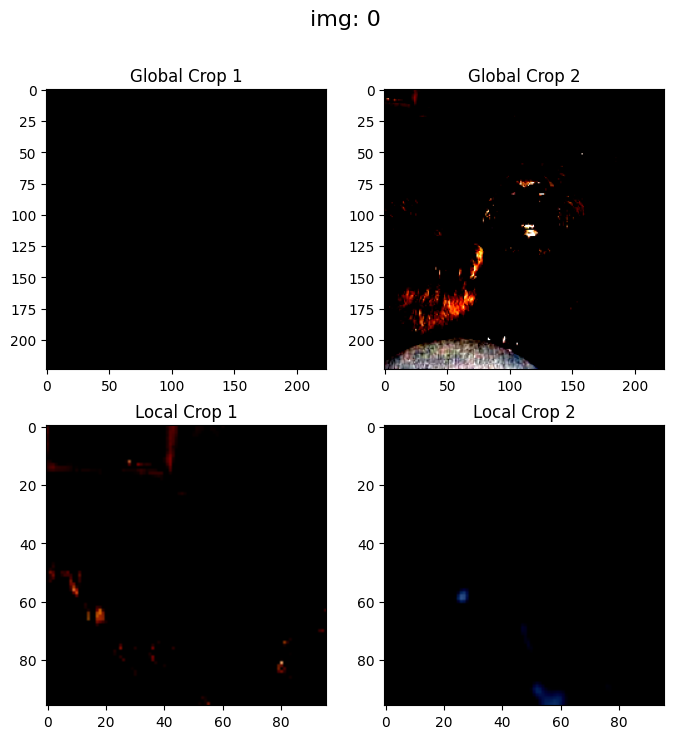

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


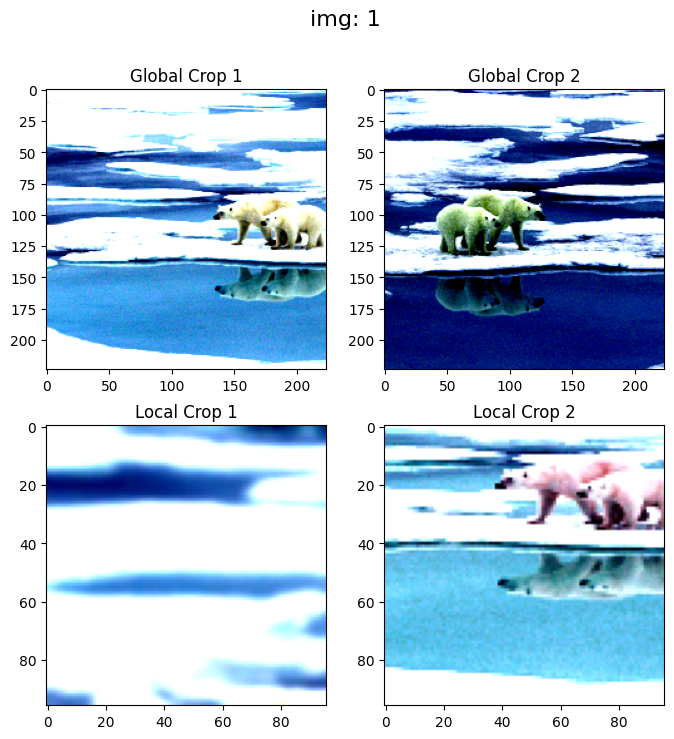

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


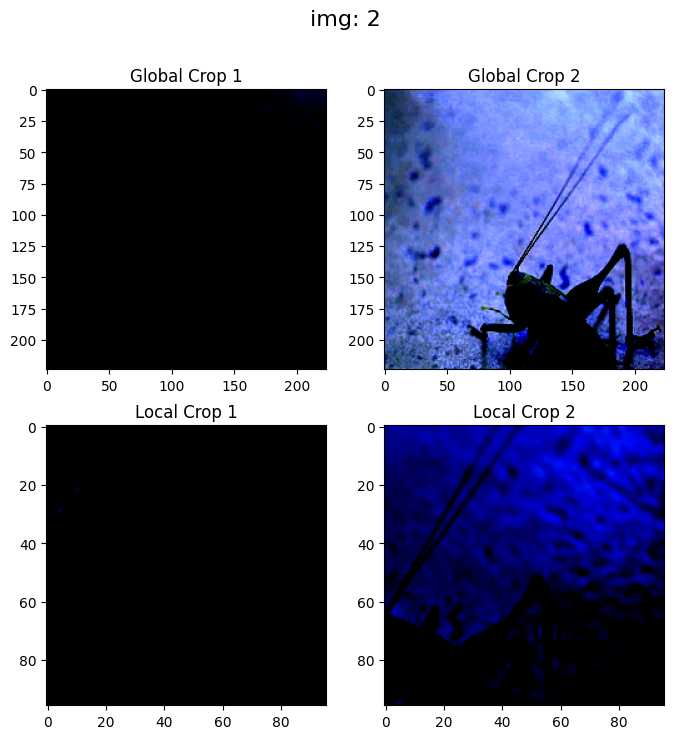

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


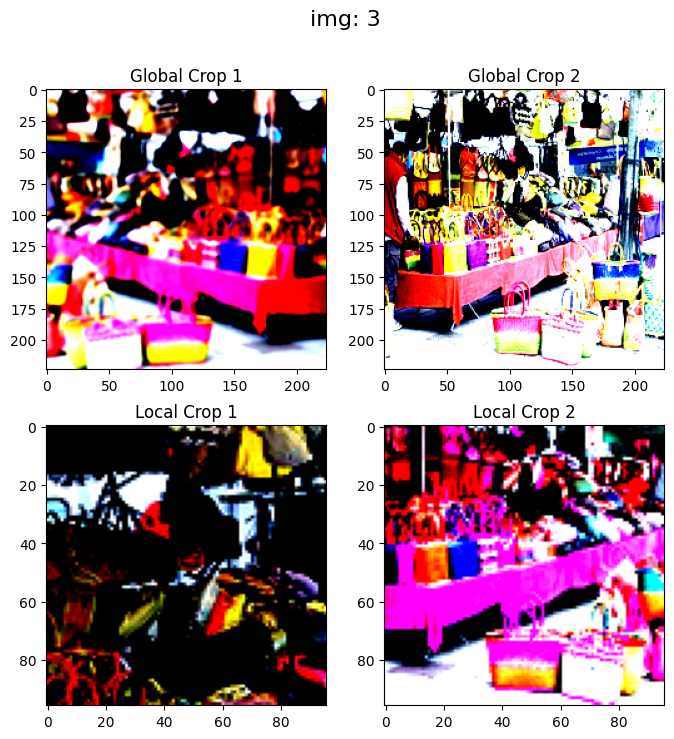

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


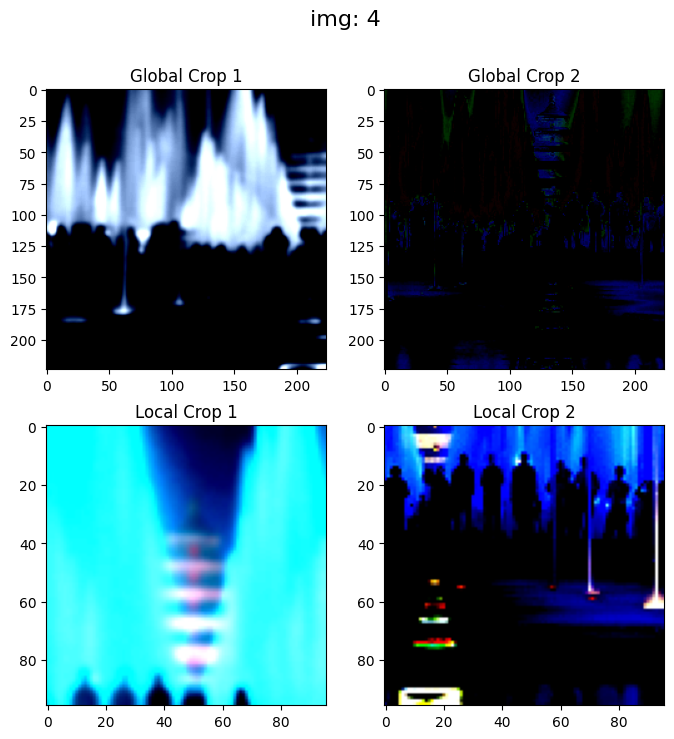

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


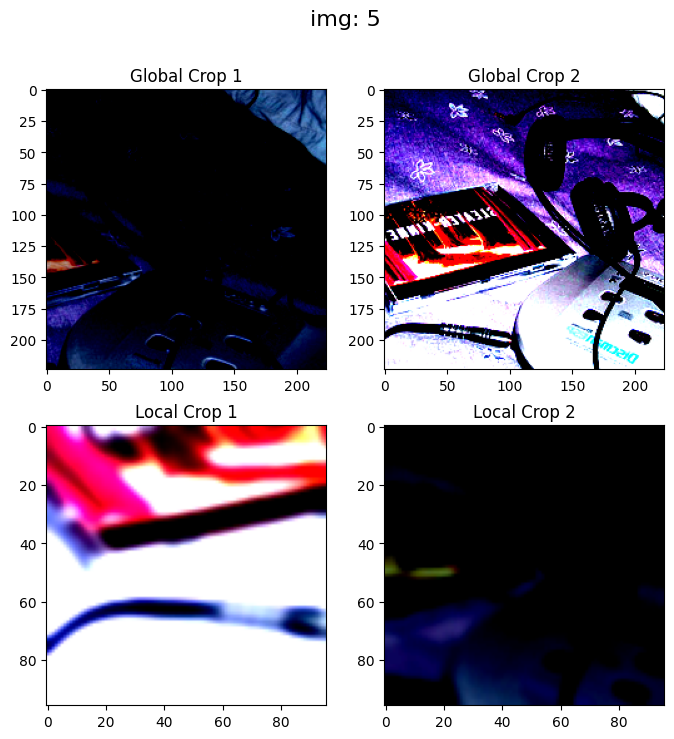

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


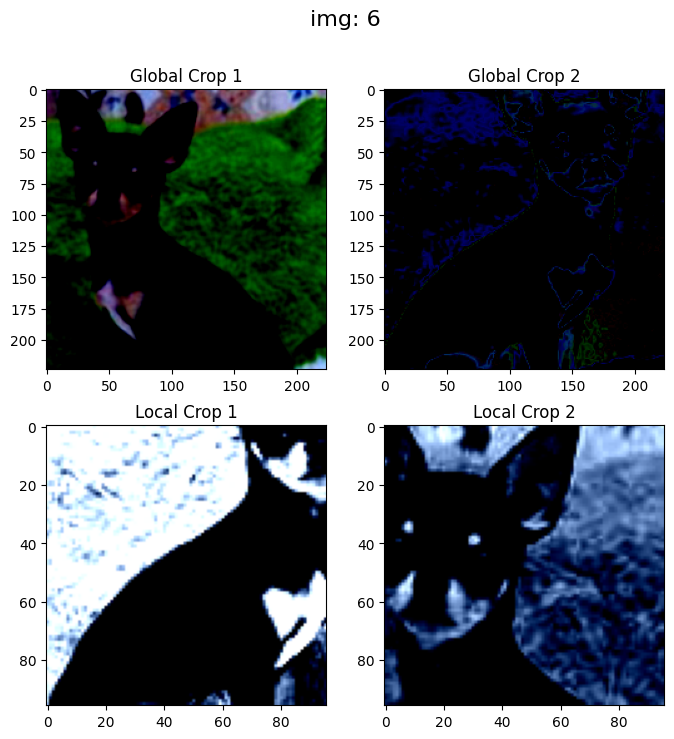

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


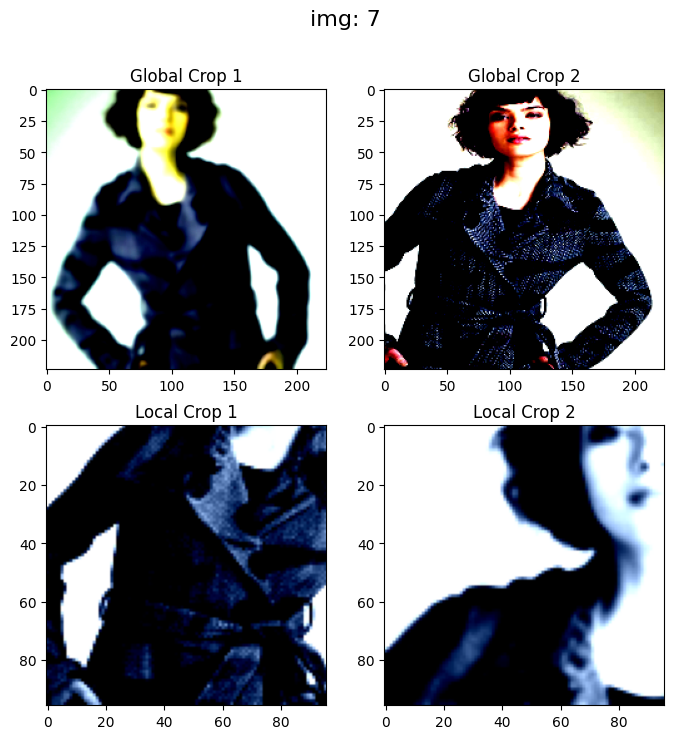

In [7]:
for idx in range(len(global_crop0)):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    fig.suptitle(f"img: {idx}", fontsize=16)

    axes[0][0].imshow(global_crop0[idx].permute(1,2,0).numpy())
    axes[0][0].set_title("Global Crop 1")

    axes[0][1].imshow(global_crop1[idx].permute(1,2,0).numpy())
    axes[0][1].set_title("Global Crop 2")

    axes[1][0].imshow(local_crop0[idx].permute(1,2,0).numpy())
    axes[1][0].set_title("Local Crop 1")

    axes[1][1].imshow(local_crop1[idx].permute(1,2,0).numpy())
    axes[1][1].set_title("Local Crop 2")

    plt.show()

In [10]:
teacher = Encoder("vit-s-16")
student = Encoder("vit-s-16")

In [11]:
teacher_outs = {
    "g0": teacher(global_crop0),
    "g1": teacher(global_crop1)
}

student_outs = {
    "g0": student(global_crop0),
    "g1": student(global_crop1)
}
for i, crop in enumerate(local_crops):
    student_out = student(crop)
    student_outs[f"l{i}"] = student_out

In [22]:
temperature = 0.5
criterion = nn.CrossEntropyLoss()

for global_crop, teacher_out in teacher_outs.items():
    teacher_out = F.softmax((teacher_out / temperature), dim=-1)
    print("teacher_crop:", global_crop)

    for crop, student_out in student_outs.items():
        if global_crop != crop:
            student_out = F.softmax((student_out / temperature), dim=-1)

            loss = -torch.sum(teacher_out * torch.log(student_out), dim=-1)
            avg_loss = loss.mean()

            print("student_crop:", crop)
            print("avg_loss:", avg_loss)
            print()

teacher_crop: g0
student_crop: g1
avg_loss: tensor(11.0907, grad_fn=<MeanBackward0>)

student_crop: l0
avg_loss: tensor(11.0907, grad_fn=<MeanBackward0>)

student_crop: l1
avg_loss: tensor(11.0907, grad_fn=<MeanBackward0>)

teacher_crop: g1
student_crop: g0
avg_loss: tensor(11.0907, grad_fn=<MeanBackward0>)

student_crop: l0
avg_loss: tensor(11.0907, grad_fn=<MeanBackward0>)

student_crop: l1
avg_loss: tensor(11.0907, grad_fn=<MeanBackward0>)



to-do:
- ema weight update for teacher
- temperature schedule
- weight decay schedule
- centering
- sharpening (confirm completion from temperature)